In [2]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
pd.options.display.max_columns=None
pd.options.display.max_rows=None
pd.options.display.float_format="{:.6f}".format
import warnings
warnings.filterwarnings("ignore")

In [3]:
data=pd.read_excel(r"C:\Users\sabaa\OneDrive\Documents\CAPSTONE PROJECT FILES\final_capstone_sequence_data.xlsx")

In [3]:
data.head()

,DNA_sequences,hosts
0,ATAGCCCTTTATAAAGTCAGTCTTCTTTTTTCAACTGATGAGTGCG...,archae
1,GCCCTTTATAAAGCCATTTTTCTTTTTTTCCTCTTGATGAGTGCGT...,archae
2,GCCCTTTATAAAGTCATAATCTTTTTTCGTTTTGATGAGTGCGTTA...,archae
3,TTTAGGTGGGACATAGGCACCACAATAAACACCACAAACACCACCA...,archae
4,TTAAATACCCCTATTTCTCATTCTATCCCAAGTCTTGTGCCCTGGC...,archae


In [6]:
data_1=data.copy()

DATA CLEANING

In [34]:
def letter_count(data):
    letter_count={}
    for i in range(len(data)):
        for j in data:
            for letter in str(j):
                if letter in letter_count:
                    letter_count[letter]+=1
                else:
                    letter_count[letter]=1
    return letter_count
    

In [35]:
letter_count(data["DNA_sequences"])

{'A': 274660155,
 'T': 271494342,
 'G': 214497711,
 'C': 212771817,
 '\n': 13998546,
 'M': 1395,
 'Y': 6975,
 'R': 4464,
 'N': 3069,
 'S': 279,
 's': 279,
 'K': 558,
 'W': 558}

In [110]:
data['DNA_sequences']=data['DNA_sequences'].apply(lambda x: x.replace('\n',''))
data['DNA_sequences']=data['DNA_sequences'].apply(lambda x: x.replace('Y',''))
data['DNA_sequences']=data['DNA_sequences'].apply(lambda x: x.replace('M',''))
data['DNA_sequences']=data['DNA_sequences'].apply(lambda x: x.replace('R',''))
data['DNA_sequences']=data['DNA_sequences'].apply(lambda x: x.replace('N',''))
data['DNA_sequences']=data['DNA_sequences'].apply(lambda x: x.replace('s',''))
data['DNA_sequences']=data['DNA_sequences'].apply(lambda x: x.replace('S',''))
data['DNA_sequences']=data['DNA_sequences'].apply(lambda x: x.replace('K',''))
data['DNA_sequences']=data['DNA_sequences'].apply(lambda x: x.replace('W',''))

In [91]:
number_of_letters=letter_count(seq_data["DNA_sequences"]) 

In [92]:
number_of_letters

{'A': 274660155, 'T': 271494342, 'G': 214497711, 'C': 212771817}

In [93]:
sum(number_of_letters.values())

973424025

In [25]:
data.shape

(279, 2)

encoding the host column

In [8]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(data.hosts)

In [9]:
data.head()

,DNA_sequences,hosts
0,ATAGCCCTTTATAAAGTCAGTCTTCTTTTTTCAACTGATGAGTGCG...,archae
1,GCCCTTTATAAAGCCATTTTTCTTTTTTTCCTCTTGATGAGTGCGT...,archae
2,GCCCTTTATAAAGTCATAATCTTTTTTCGTTTTGATGAGTGCGTTA...,archae
3,TTTAGGTGGGACATAGGCACCACAATAAACACCACAAACACCACCA...,archae
4,TTAAATACCCCTATTTCTCATTCTATCCCAAGTCTTGTGCCCTGGC...,archae


CONVERTING SEQUENCES INTO KMERS

In [10]:
def getKmers(seq, size):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]

In [11]:
df_kmers=pd.DataFrame([data['DNA_sequences'].apply(lambda x: ' '.join(getKmers(seq=x,size=6))),y],index=['DNA','host']).T

In [12]:
df_kmers.head()

,DNA,host
0,atagcc tagccc agccct gccctt cccttt ccttta cttt...,0
1,gccctt cccttt ccttta ctttat tttata ttataa tata...,0
2,gccctt cccttt ccttta ctttat tttata ttataa tata...,0
3,tttagg ttaggt taggtg aggtgg ggtggg gtggga tggg...,0
4,ttaaat taaata aaatac aatacc ataccc tacccc accc...,0


In [13]:
df_kmers.host.value_counts()

0    35
1    35
4    35
5    35
6    35
7    35
3    35
2    34
Name: host, dtype: int64

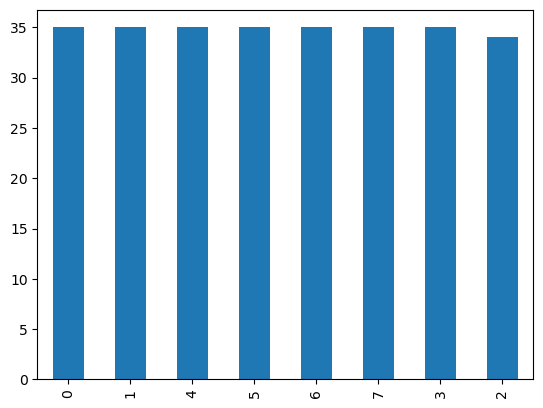

In [14]:
df_kmers["host"].value_counts().plot(kind="bar")
plt.show()

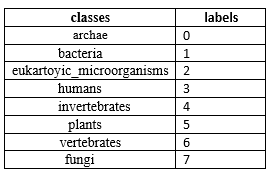

In [49]:
from IPython.display import Image
image_path =("C:\\Users\\sabaa\\OneDrive\\Documents\\CAPSTONE PROJECT FILES\\class_labels.png")
Image(filename=image_path)


In [15]:
#use this only if there is error in k folds
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df_kmers["host"] = encoder.fit_transform(df_kmers["host"])

### using stratified kfold for train test split

With a relatively small dataset like 35 sequences per class, using a simple train-test split can indeed lead to imbalanced training and testing sets, which can impact the performance and generalization of your classification model. Imbalanced data can result in biased models that perform well on the majority class but struggle with the minority classes.

Instead of a single train-test split, use techniques like k-fold cross-validation. Cross-validation involves dividing your dataset into k subsets (folds) and training/testing your model k times, with each fold serving as the testing set once. This helps in obtaining more reliable performance estimates and better generalization.

In [16]:
from sklearn.model_selection import StratifiedKFold

# Creating dataset and target variables
X=df_kmers["DNA"]
y=df_kmers["host"]

# Specifying the number of folds
n_splits = 10 

# Create an instance of StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Iterate through the folds
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

using count vectorizer to  transform the data to document term matrix

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
cv = CountVectorizer() 
cv.fit(X_train)
X_train_dtm = cv.transform(X_train)
X_test_dtm = cv.transform(X_test)

model building for heaxamer dna sequences

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

### using classification models

In [20]:
from sklearn.naive_bayes import MultinomialNB

In [89]:
accuracy = []
f1_score_= []
precision= []
recall= []

knn = KNeighborsClassifier()
mnb= MultinomialNB()
nb = GaussianNB()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
gb = GradientBoostingClassifier()
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1)  # Adjust hyperparameters accordingly

models = [knn, mnb, nb, dt, rf, ada, gb, xgb]

for model in models:
    mod=model.fit(X_train_dtm.toarray(), y_train)
    y_pred = mod.predict(X_test_dtm.toarray())
    
    model_accuracy = accuracy_score(y_test, y_pred)
    model_f1_score=f1_score(y_test,y_pred,average='micro')
    model_precision=precision_score(y_test,y_pred,average='micro')
    model_recall=recall_score(y_test,y_pred,average='micro')
    
    accuracy.append(model_accuracy)
    precision.append(model_precision)
    recall.append(model_recall)

print("accuracy: ",accuracy)
print("f1_score: ",f1_score)
print("precision: ",precision)
print("recall: ",recall)

accuracy:  [0.48148148148148145, 0.25925925925925924, 0.25925925925925924, 0.37037037037037035, 0.5555555555555556, 0.18518518518518517, 0.4444444444444444, 0.5555555555555556]
f1_score:  <function f1_score at 0x000001CA4CE365F0>
precision:  [0.48148148148148145, 0.25925925925925924, 0.25925925925925924, 0.37037037037037035, 0.5555555555555556, 0.18518518518518517, 0.4444444444444444, 0.5555555555555556]
recall:  [0.48148148148148145, 0.25925925925925924, 0.25925925925925924, 0.37037037037037035, 0.5555555555555556, 0.18518518518518517, 0.4444444444444444, 0.5555555555555556]


In [90]:
df_accuracy=pd.DataFrame({"MODEL":["KNeighborsClassifier","MultinomialNB","NaiveBayes","DecisionTree","RandomForest",
                                   "AdaBoostClassifier","GradientBoosting"
                          ,"XGBClassifier"],"accuracy(k=6)":accuracy,
                          "precision(k=6)":precision,"recall(k=6)":recall})
df_accuracy

,MODEL,accuracy(k=6),precision(k=6),recall(k=6)
0,KNeighborsClassifier,0.481481,0.481481,0.481481
1,MultinomialNB,0.259259,0.259259,0.259259
2,NaiveBayes,0.259259,0.259259,0.259259
3,DecisionTree,0.370370,0.370370,0.370370
4,RandomForest,0.555556,0.555556,0.555556
5,AdaBoostClassifier,0.185185,0.185185,0.185185
6,GradientBoosting,0.444444,0.444444,0.444444
7,XGBClassifier,0.555556,0.555556,0.555556


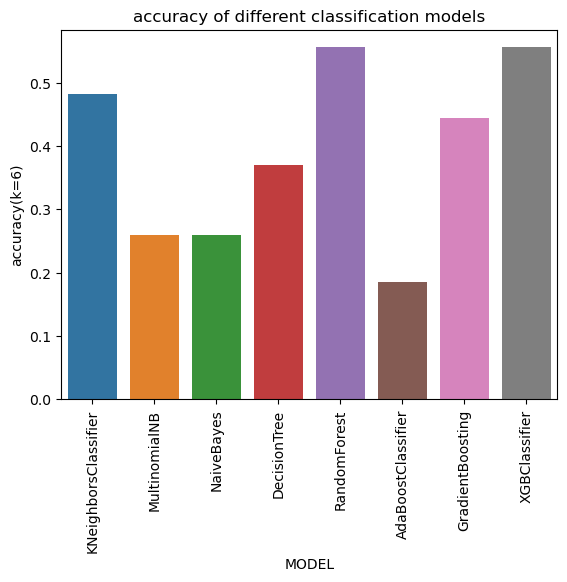

In [91]:
sns.barplot(data=df_accuracy,x="MODEL",y="accuracy(k=6)")
plt.xticks(rotation="vertical")
plt.title("accuracy of different classification models")
plt.show()

The best accuracy among all the base models is given by random forest classifier

### devoloping base models for different values of k

In [84]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df_kmers["host"] = encoder.fit_transform(df_kmers["host"])

In [94]:
nb_accuracy = []
knn_accuracy = []
dt_accuracy = []
rf_accuracy = []
ada_accuracy = []
gb_accuracy = []
xgb_accuracy = []
    

for i in range(3,10):
    df_kmers=pd.DataFrame([data['DNA_sequences'].apply(lambda x: ' '.join(getKmers(seq=x,size=i))),y],index=['DNA','host']).T
    
    encoder = LabelEncoder()
    df_kmers["host"] = encoder.fit_transform(df_kmers["host"])
    
    X=df_kmers["DNA"]
    y=df_kmers["host"]
    n_splits = 10 
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
    cv = CountVectorizer() 
    cv.fit(X_train)
    X_train_dtm = cv.transform(X_train)
    X_test_dtm = cv.transform(X_test)
    
    
    nb = MultinomialNB()
    knn =KNeighborsClassifier()
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    ada = AdaBoostClassifier()
    gb = GradientBoostingClassifier()
    xgb = XGBClassifier(n_estimators=100, learning_rate=0.1)
   
    nb_model = nb.fit(X_train_dtm,y_train)
    nb_accuracy.append(accuracy_score(y_test,nb_model.predict(X_test_dtm)))
    
    knn_model = knn.fit(X_train_dtm,y_train)
    knn_accuracy.append(accuracy_score(y_test,knn_model.predict(X_test_dtm)))
    
    dt_model = dt.fit(X_train_dtm,y_train)
    dt_accuracy.append(accuracy_score(y_test,dt_model.predict(X_test_dtm)))
    
    rf_model = rf.fit(X_train_dtm,y_train)
    rf_accuracy.append(accuracy_score(y_test,rf_model.predict(X_test_dtm)))
    
    ada_model = ada.fit(X_train_dtm,y_train)
    ada_accuracy.append(accuracy_score(y_test,ada_model.predict(X_test_dtm)))
    
    gb_model = gb.fit(X_train_dtm,y_train)
    gb_accuracy.append(accuracy_score(y_test,gb_model.predict(X_test_dtm)))
    
    xgb_model = xgb.fit(X_train_dtm,y_train)
    xgb_accuracy.append(accuracy_score(y_test,xgb_model.predict(X_test_dtm)))


In [96]:
accuracy_df = pd.DataFrame(columns=['k','naive_bayes_accuracy','knn_accuracy','decisiontree_accuracy','random_forest_accuracy','AdaBoosting_accuracy','GradientBoosting_accuracy','xgb_accuracy'])

accuracy_df.k = [i for i in range(3,10)]
accuracy_df['knn_accuracy'] = np.round(knn_accuracy,2)
accuracy_df['decisiontree_accuracy'] = np.round(dt_accuracy,2)
accuracy_df['random_forest_accuracy'] = np.round(rf_accuracy,2)
accuracy_df['naive_bayes_accuracy'] = np.round(nb_accuracy,2)
accuracy_df['AdaBoosting_accuracy'] = np.round(ada_accuracy,2)
accuracy_df['GradientBoosting_accuracy'] = np.round(gb_accuracy,2)
accuracy_df['xgb_accuracy'] = np.round(xgb_accuracy,2)

accuracy_df

,k,naive_bayes_accuracy,knn_accuracy,decisiontree_accuracy,random_forest_accuracy,AdaBoosting_accuracy,GradientBoosting_accuracy,xgb_accuracy
0,3,0.260000,0.480000,0.410000,0.560000,0.190000,0.440000,0.560000
1,4,0.260000,0.520000,0.440000,0.480000,0.110000,0.480000,0.370000
2,5,0.300000,0.480000,0.220000,0.520000,0.220000,0.370000,0.440000
3,6,0.330000,0.410000,0.370000,0.410000,0.190000,0.370000,0.410000
4,7,0.330000,0.300000,0.190000,0.410000,0.190000,0.410000,0.410000
5,8,0.410000,0.260000,0.260000,0.330000,0.150000,0.260000,0.370000
6,9,0.330000,0.220000,0.300000,0.300000,0.220000,0.260000,0.260000


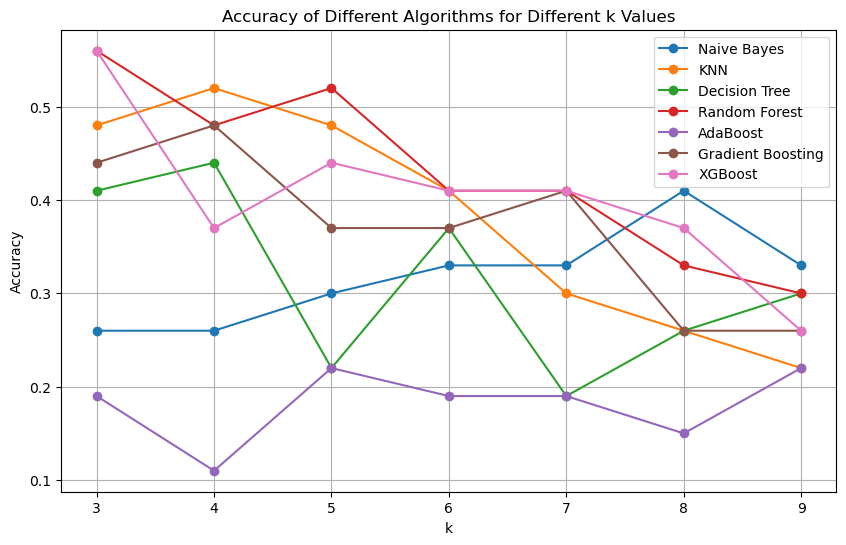

In [103]:
plt.figure(figsize=(10, 6))

plt.plot(accuracy_df.k,accuracy_df.naive_bayes_accuracy, marker='o', label='Naive Bayes')
plt.plot(accuracy_df.k, accuracy_df.knn_accuracy, marker='o', label='KNN')
plt.plot(accuracy_df.k, accuracy_df.decisiontree_accuracy, marker='o', label='Decision Tree')
plt.plot(accuracy_df.k, accuracy_df.random_forest_accuracy, marker='o', label='Random Forest')
plt.plot(accuracy_df.k, accuracy_df.AdaBoosting_accuracy, marker='o', label='AdaBoost')
plt.plot(accuracy_df.k, accuracy_df.GradientBoosting_accuracy, marker='o', label='Gradient Boosting')
plt.plot(accuracy_df.k, accuracy_df.xgb_accuracy, marker='o', label='XGBoost')

plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Algorithms for Different k Values')
plt.legend()
plt.grid()

plt.show()

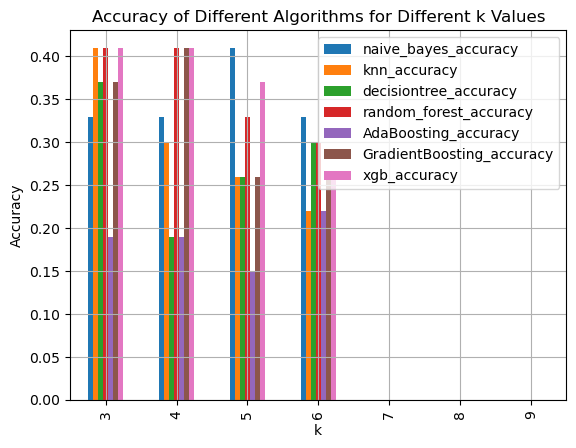

In [120]:
pd.DataFrame(accuracy_df.iloc[:,1:],index=accuracy_df["k"]).plot(kind="bar")
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Algorithms for Different k Values')
plt.legend()
plt.grid()

plt.show()

conclusion: the highest accuracy is achieved with k value 3 and with models xgboost and random forest

#### hyperparameter tuning using gridsearch cv

In [21]:
from sklearn.model_selection import GridSearchCV

#### random forest classifier

In [ ]:
param_grid={"criterion":["gini", "entropy", "log_loss"],
           'max_depth'        : [4,6,8],
            'min_samples_leaf' : [3,15,30],
            'min_samples_split': [2,4,6],
            'n_estimators'     : [300,500,1000]}

rfc=RandomForestClassifier()
grid_search=GridSearchCV(estimator=rfc,param_grid=param_grid,cv=3)
grid_search.fit(X_train_dtm,y_train)
print(grid_search.best_params_)

In [17]:
rfc=RandomForestClassifier(criterion= 'entropy', max_depth= 10, min_samples_leaf= 3,
                           min_samples_split=30, n_estimators=300)
rfc.fit(X_train_dtm,y_train)
print("the accuracy for the random foresr classifier model is ",accuracy_score(y_test,rfc.predict(X_test_dtm)))

the accuracy for the random foresr classifier model is  0.2962962962962963


#### XGBclassifier

In [20]:
# gamma: pass the list of minimum loss reduction values required to make a further partition on a leaf node of the tree
tuning_parameters = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                     'max_depth': range(3,10),
                     'gamma': [0, 1, 2, 3, 4]}
xgb=XGBClassifier()
grid_search=GridSearchCV(estimator=xgb,param_grid=tuning_parameters,cv=3,scoring="accuracy")
grid_search.fit(X_train_dtm,y_train)
print(grid_search.best_params_)

{'gamma': 0, 'learning_rate': 0.4, 'max_depth': 4}


In [23]:
xgb=XGBClassifier(gamma= 0,learning_rate=0.4, max_depth=4)
xgb_model=xgb.fit(X_train_dtm,y_train)
print("the accuracy for the xgb classifier model is ",accuracy_score(y_test,xgb.predict(X_test_dtm)))

the accuracy for the xgb classifier model is  0.3333333333333333


### DEEP LEARNING MODELS

In [216]:
data.shape

(279, 2)

In [217]:
def Kmers_funct(seq, size=5):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]

In [218]:
data['words'] = data.apply(lambda x: Kmers_funct(x['DNA_sequences']), axis=1)
data = data.drop('DNA_sequences', axis=1)

In [219]:
sequence = list(data['words'])
for item in range(len(sequence)):
    sequence[item] = ' '.join(sequence[item])
#separate labels
Yhost = data.iloc[:, 0].values 

In [220]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4)) #The n-gram size of 4 is previously determined by testing
X_Sequence = cv.fit_transform(sequence)

In [221]:
X_Sequence.shape

(279, 117906)

So, for humans we have 280 genes converted into uniform length feature vectors of 4-gram k-mer (length 6) counts

In [222]:
from sklearn.model_selection import StratifiedKFold

# Creating dataset and target variables
X=X_Sequence
y=Yhost

# Specifying the number of folds
n_splits = 10 

# Create an instance of StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)

# Iterate through the folds
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

### Applying CNN Model

In [41]:
pip install keras

     ---------------------------------------- 1.7/1.7 MB 3.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [43]:
pip install tensorflow

     -------------------------------------- 276.5/276.5 MB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 24.4/24.4 MB 4.0 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 3.5 MB/s eta 0:00:00
     -------------------------------------- 440.8/440.8 kB 3.9 MB/s eta 0:00:00
     ---------------------------------------- 5.6/5.6 MB 4.1 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 4.5 MB/s eta 0:00:00
     -------------------------------------- 430.4/430.4 kB 3.8 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 4.3/4.3 MB 3.3 MB/s eta 0:00:00
     -------------------------------------- 126.5/126.5 kB 3.8 MB/s eta 0:00:00
     -------------------------------------- 181.8/181.8 kB 3.6 MB/s eta 0:00:00
     -------------------------------------- 151.7/151.7 kB 4.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to us

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mysql-connector-python 8.0.32 requires protobuf<=3.20.3,>=3.11.0, but you have protobuf 4.24.2 which is incompatible.


In [5]:
import keras
from keras.models import Sequential
from keras.layers import LSTM ,Bidirectional ,Dense,Activation ,Input
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import tensorflow as tf
from typing import List
from typing import List
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from pathlib import Path

In [6]:
def build_kmers(sequence:str, k:int)->List[str]:
    """
        inputs:
                sequence: a sting that represent a DNA
                k: parameter to produce k-mer list
        return: list of kmers
    """
    kmers = []
    n_kmers = len(sequence) - k + 1

    for i in range(n_kmers):
        kmer = sequence[i:i + k]
        kmers.append(kmer)

    return kmers

In [7]:
data["len"] =data["DNA_sequences"].apply(lambda x:len(x))
data.head()

,DNA_sequences,hosts,len
0,ATAGCCCTTTATAAAGTCAGTCTTCTTTTTTCAACTGATGAGTGCG...,archae,17855
1,GCCCTTTATAAAGCCATTTTTCTTTTTTTCCTCTTGATGAGTGCGT...,archae,16710
2,GCCCTTTATAAAGTCATAATCTTTTTTCGTTTTGATGAGTGCGTTA...,archae,17635
3,TTTAGGTGGGACATAGGCACCACAATAAACACCACAAACACCACCA...,archae,15910
4,TTAAATACCCCTATTTCTCATTCTATCCCAAGTCTTGTGCCCTGGC...,archae,13967


In [8]:
data["k-mers"] = data["DNA_sequences"].apply(lambda x :build_kmers(x,5))
data.head()

,DNA_sequences,hosts,len,k-mers
0,ATAGCCCTTTATAAAGTCAGTCTTCTTTTTTCAACTGATGAGTGCG...,archae,17855,"[ATAGC, TAGCC, AGCCC, GCCCT, CCCTT, CCTTT, CTT..."
1,GCCCTTTATAAAGCCATTTTTCTTTTTTTCCTCTTGATGAGTGCGT...,archae,16710,"[GCCCT, CCCTT, CCTTT, CTTTA, TTTAT, TTATA, TAT..."
2,GCCCTTTATAAAGTCATAATCTTTTTTCGTTTTGATGAGTGCGTTA...,archae,17635,"[GCCCT, CCCTT, CCTTT, CTTTA, TTTAT, TTATA, TAT..."
3,TTTAGGTGGGACATAGGCACCACAATAAACACCACAAACACCACCA...,archae,15910,"[TTTAG, TTAGG, TAGGT, AGGTG, GGTGG, GTGGG, TGG..."
4,TTAAATACCCCTATTTCTCATTCTATCCCAAGTCTTGTGCCCTGGC...,archae,13967,"[TTAAA, TAAAT, AAATA, AATAC, ATACC, TACCC, ACC..."


### wordEmbedding

In [9]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: gensim in c:\users\sabaa\anaconda3\lib\site-packages (4.3.0)



In [10]:
from gensim.models import word2vec

In [11]:
class DocToVec:
    
    def __init__(self, dataset:List[List] , vec_size = 200 , model_path = 'word2vec.model'):
        """ Here we train our model and calculate tf-idf weights.

        Args:
            dataset (List[List]): Each item of this list is a list of tokens obtained from a document.
            vec_size (int, optional): The size of the vector of each document. Defaults to 200.
            model_path (str, optional): The path of pre-trained model. If there is no file in the specified 
            path, It trains a model with the dataset and saves the trained model. Defaults to 'word2vec.model'.
        """

        self.vec_size = vec_size
        
        
        
        if not Path(model_path).is_file():
            print('There is no pre-trained model. Going to train a model ...')
            self.wordToVecModel = Word2Vec(
                window = 10,
                min_count=2,
                workers=4,
                vector_size = self.vec_size
            )
        
            self.wordToVecModel.build_vocab(dataset)
            
            self.wordToVecModel.train(
                dataset,
                total_examples = self.wordToVecModel.corpus_count,
                epochs = 20,
            )
            
            self.wordToVecModel.save(model_path)
            
        else:
            
            print('Loading the model ...')
            self.wordToVecModel = Word2Vec.load(model_path)
        
        con_train_data = [" ".join(a) for a in dataset]
        
        self.tfIdfVectorizer=TfidfVectorizer(use_idf=True,
                                        dtype = np.float64,
                                        lowercase = False,
                                        vocabulary = self.wordToVecModel.wv.index_to_key)
        
        self.tfIdfVectorizer.fit(con_train_data)
        
        dictionary = self.tfIdfVectorizer.get_feature_names_out()
        self.dictToNum = {d:i for i,d in enumerate(dictionary)}
        
        
    def embed(self, tokens:List):
        """Maps the input to a vector

        Args:
            tokens (List): List of tokens (don't forget to do preprocessing before 
            extracting tokens)

        Returns:
            Numpy Array: The vector of document
        """
        
        ti = self.tfIdfVectorizer.transform([" ".join(tokens)])
        
        weights = np.squeeze(np.asarray(ti[0].T.todense()))
        
        vec = np.zeros((self.vec_size,))
        sum_weights = 0
        for k in set(tokens):
            try:
                word_vec = self.wordToVecModel.wv[k]
                weight = weights[self.dictToNum[k]]
                vec += word_vec * weight
                sum_weights += weight
            except KeyError:
                pass
        vec /= sum_weights
        return vec

In [12]:
word_to_vec_model = DocToVec(dataset=data["k-mers"].to_list())
data["vec"]= data["k-mers"].apply(lambda x:word_to_vec_model.embed(x))
data.head()

Loading the model ...


,DNA_sequences,hosts,len,k-mers,vec
0,ATAGCCCTTTATAAAGTCAGTCTTCTTTTTTCAACTGATGAGTGCG...,archae,17855,"[ATAGC, TAGCC, AGCCC, GCCCT, CCCTT, CCTTT, CTT...","[0.012399773544295223, 0.046965433223848, -0.0..."
1,GCCCTTTATAAAGCCATTTTTCTTTTTTTCCTCTTGATGAGTGCGT...,archae,16710,"[GCCCT, CCCTT, CCTTT, CTTTA, TTTAT, TTATA, TAT...","[0.04423111372861986, 0.0035352329369713487, 0..."
2,GCCCTTTATAAAGTCATAATCTTTTTTCGTTTTGATGAGTGCGTTA...,archae,17635,"[GCCCT, CCCTT, CCTTT, CTTTA, TTTAT, TTATA, TAT...","[0.044307925794832635, 0.049663228452925014, -..."
3,TTTAGGTGGGACATAGGCACCACAATAAACACCACAAACACCACCA...,archae,15910,"[TTTAG, TTAGG, TAGGT, AGGTG, GGTGG, GTGGG, TGG...","[0.04410436481219431, 0.02498892859816544, 0.0..."
4,TTAAATACCCCTATTTCTCATTCTATCCCAAGTCTTGTGCCCTGGC...,archae,13967,"[TTAAA, TAAAT, AAATA, AATAC, ATACC, TACCC, ACC...","[0.04757513191057538, 0.22608371461953336, -0...."


In [13]:
y= data["hosts"].to_list()

In [14]:
X = np.array(data["vec"].to_list())

# change to np
le = preprocessing.LabelEncoder()
y =le.fit_transform(y)

In [15]:
from sklearn.model_selection import StratifiedKFold

# Specifying the number of folds
n_splits = 10 

# Create an instance of StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)

# Iterate through the folds
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [16]:
from keras import losses 
from keras import optimizers 
from keras import metrics 

In [17]:
model_cnn =Sequential()
model_cnn.add(Input(shape=(200,)))
model_cnn.add(Dense(100, activation='relu'))
model_cnn.add(Dense(50,activation='relu'))
model_cnn.add(Dense(8))

model_cnn.summary()

In [19]:
model_cnn.compile(loss = "sparse_categorical_crossentropy",optimizer = "adam", metrics = [metrics.categorical_accuracy])

In [21]:
model_output_cnn = model_cnn.fit(X_train,y_train,epochs=35,batch_size=32,verbose=1,validation_data=(X_test,y_test))

Epoch 1/35
8/8 [==============================] - 0s 13ms/step - loss: 2.0794 - categorical_accuracy: 0.0675 - val_loss: 2.0794 - val_categorical_accuracy: 0.0370
Epoch 2/35
8/8 [==============================] - 0s 8ms/step - loss: 2.0794 - categorical_accuracy: 0.0675 - val_loss: 2.0794 - val_categorical_accuracy: 0.0370
Epoch 3/35
8/8 [==============================] - 0s 9ms/step - loss: 2.0794 - categorical_accuracy: 0.0675 - val_loss: 2.0794 - val_categorical_accuracy: 0.0370
Epoch 4/35
8/8 [==============================] - 0s 9ms/step - loss: 2.0794 - categorical_accuracy: 0.0675 - val_loss: 2.0794 - val_categorical_accuracy: 0.0370
Epoch 5/35
8/8 [==============================] - 0s 7ms/step - loss: 2.0794 - categorical_accuracy: 0.0675 - val_loss: 2.0794 - val_categorical_accuracy: 0.0370
Epoch 6/35
8/8 [==============================] - 0s 9ms/step - loss: 2.0794 - categorical_accuracy: 0.0675 - val_loss: 2.0794 - val_categorical_accuracy: 0.0370
Epoch 7/35
8/8 [===========

In [22]:
# Evaluate the model on the test data
loss, accuracy = model_cnn.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

1/1 [==============================] - 0s 35ms/step - loss: 2.0794 - categorical_accuracy: 0.0370
Test Loss: 2.0794413089752197, Test Accuracy: 0.03703703731298447


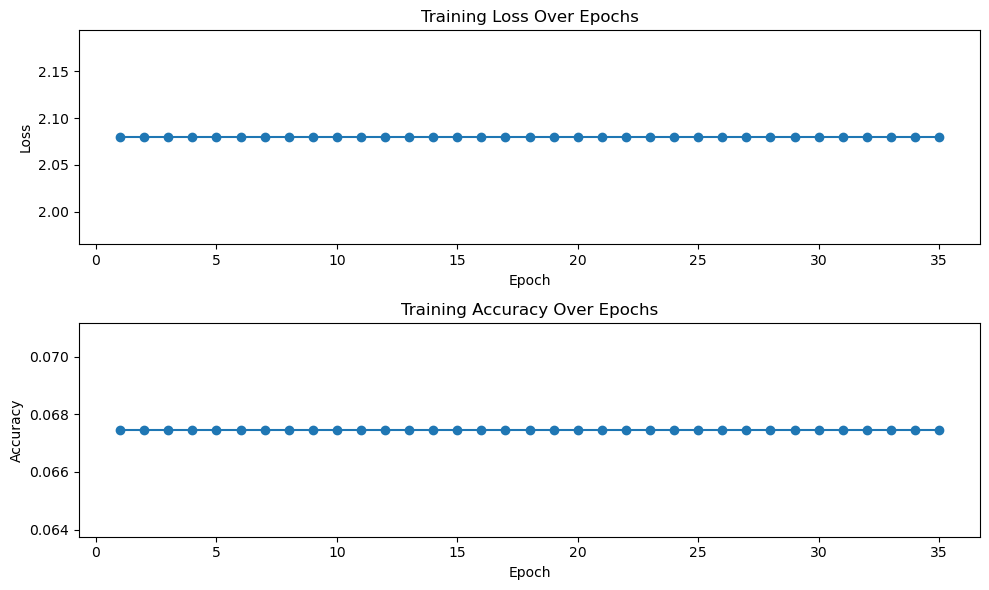

In [23]:
loss_values=model_output_cnn.history["loss"]
accuracy_values=model_output_cnn.history["categorical_accuracy"]

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,6))

#for training loss
ax1.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Over Epochs')

# Plot the training accuracy
ax2.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker='o', linestyle='-')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy Over Epochs')

plt.tight_layout()
plt.show()

using normal train test split

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
model_cnn_2 =Sequential()
model_cnn_2.add(Input(shape=(200,)))
model_cnn_2.add(Dense(100,activation='relu'))
model_cnn_2.add(Dense(50,activation='relu'))
model_cnn_2.add(Dense(8))

In [27]:
model_cnn_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               20100     
                                                                 
 dense_7 (Dense)             (None, 50)                5050      
                                                                 
 dense_8 (Dense)             (None, 8)                 408       
                                                                 
Total params: 25558 (99.84 KB)
Trainable params: 25558 (99.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
model_cnn_2.compile(loss = "sparse_categorical_crossentropy",optimizer = "adam", metrics = [metrics.categorical_accuracy])

In [30]:
model_output_cnn_2 = model_cnn_2.fit(X_train,y_train,epochs=34,batch_size=32,verbose=1,validation_data=(X_test,y_test))

Epoch 1/34
7/7 [==============================] - 1s 27ms/step - loss: 6.7817 - categorical_accuracy: 0.0000e+00 - val_loss: 7.0319 - val_categorical_accuracy: 0.0000e+00
Epoch 2/34
7/7 [==============================] - 0s 8ms/step - loss: 5.6556 - categorical_accuracy: 0.0045 - val_loss: 7.2502 - val_categorical_accuracy: 0.0000e+00
Epoch 3/34
7/7 [==============================] - 0s 10ms/step - loss: 5.0375 - categorical_accuracy: 0.0135 - val_loss: 6.4720 - val_categorical_accuracy: 0.0000e+00
Epoch 4/34
7/7 [==============================] - 0s 10ms/step - loss: 4.7067 - categorical_accuracy: 0.0090 - val_loss: 5.6304 - val_categorical_accuracy: 0.0179
Epoch 5/34
7/7 [==============================] - 0s 12ms/step - loss: 4.1821 - categorical_accuracy: 0.0090 - val_loss: 4.8425 - val_categorical_accuracy: 0.0179
Epoch 6/34
7/7 [==============================] - 0s 9ms/step - loss: 3.9202 - categorical_accuracy: 0.0090 - val_loss: 4.1259 - val_categorical_accuracy: 0.0179
Epoch 7/

In [31]:
# Evaluate the model on the test data
loss, accuracy = model_cnn_2.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

2/2 [==============================] - 0s 4ms/step - loss: 5.1412 - categorical_accuracy: 0.0357
Test Loss: 5.141239643096924, Test Accuracy: 0.0357142873108387


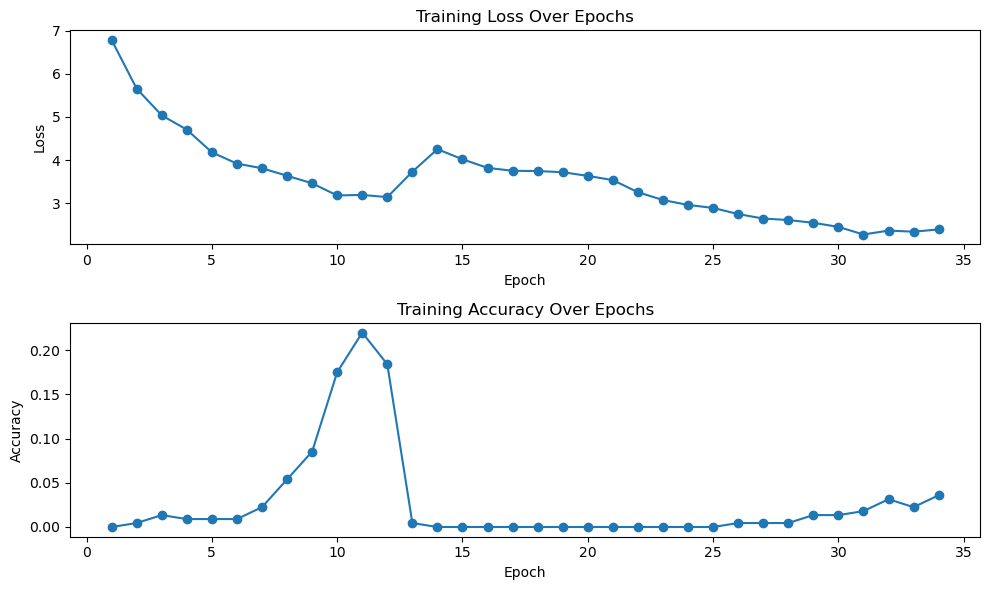

In [32]:
loss_values=model_output_cnn_2.history["loss"]
accuracy_values=model_output_cnn_2.history["categorical_accuracy"]

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,6))

#for training loss
ax1.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Over Epochs')

# Plot the training accuracy
ax2.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker='o', linestyle='-')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy Over Epoch

plt.tight_layout()
plt.show()

## LSTM

In [37]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Prepare the input sequences
max_sequence_length = 100  # You can adjust this based on your data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['DNA_sequences'])
sequences = tokenizer.texts_to_sequences(data['DNA_sequences'])
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Prepare the target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['hosts'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_sequence_length))
model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(8, activation='softmax'))  # 8 output classes, one for each host

# Compile the model
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_output_lstm=model_lstm.fit(X_train, y_train, epochs=35, batch_size=64, validation_split=0.2)

Epoch 1/35
3/3 [==============================] - 4s 552ms/step - loss: 2.0803 - accuracy: 0.1236 - val_loss: 2.0810 - val_accuracy: 0.1111
Epoch 2/35
3/3 [==============================] - 1s 202ms/step - loss: 2.0734 - accuracy: 0.1461 - val_loss: 2.0820 - val_accuracy: 0.1111
Epoch 3/35
3/3 [==============================] - 1s 212ms/step - loss: 2.0610 - accuracy: 0.1629 - val_loss: 2.0795 - val_accuracy: 0.1111
Epoch 4/35
3/3 [==============================] - 1s 235ms/step - loss: 2.0155 - accuracy: 0.3202 - val_loss: 2.1045 - val_accuracy: 0.1556
Epoch 5/35
3/3 [==============================] - 1s 226ms/step - loss: 1.9274 - accuracy: 0.2978 - val_loss: 2.1431 - val_accuracy: 0.1333
Epoch 6/35
3/3 [==============================] - 1s 236ms/step - loss: 1.7628 - accuracy: 0.3202 - val_loss: 2.1131 - val_accuracy: 0.1556
Epoch 7/35
3/3 [==============================] - 1s 234ms/step - loss: 1.6231 - accuracy: 0.2809 - val_loss: 2.2156 - val_accuracy: 0.1333
Epoch 8/35
3/3 [====

In [38]:
# Evaluate the model on the test data
loss, accuracy = model_lstm.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


2/2 [==============================] - 0s 27ms/step - loss: 3.5174 - accuracy: 0.2679
Test Loss: 3.5173964500427246, Test Accuracy: 0.2678571343421936


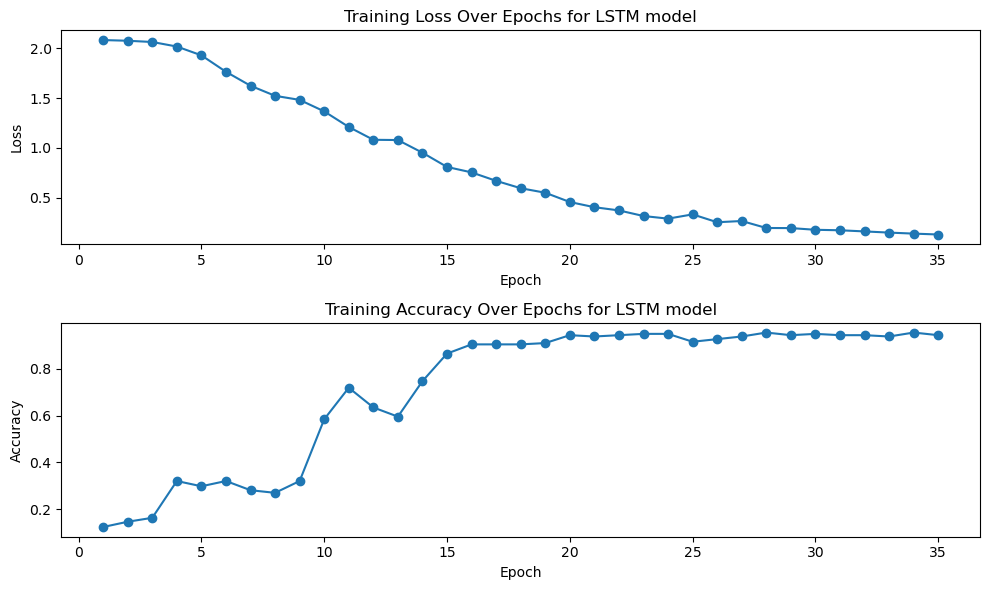

In [40]:
loss_values=model_output_lstm.history["loss"]
accuracy_values=model_output_lstm.history["accuracy"]

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,6))

#for training loss
ax1.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')ax1

ax1.set_title('Training Loss Over Epochs for LSTM model')

# Plot the training accuracy
ax2.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker='o', linestyle='-')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy Over Epochs for LSTM model')

plt.tight_layout()
plt.show()

### using stratitified k fold

In [41]:
# Prepare the input sequences
max_sequence_length = 100  # You can adjust this based on your data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['DNA_sequences'])
sequences = tokenizer.texts_to_sequences(data['DNA_sequences'])
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Prepare the target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['hosts'])

# Specifying the number of folds
n_splits = 10 

# Create an instance of StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)

# Iterate through the folds
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Define the LSTM model
model_lstm_2 = Sequential()
model_lstm_2.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_sequence_length))
model_lstm_2.add(LSTM(128, return_sequences=True))
model_lstm_2.add(LSTM(64))
model_lstm_2.add(Dense(8, activation='softmax'))  # 8 output classes, one for each host

# Compile the model
model_lstm_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_lstm_2_output=model_lstm_2.fit(X_train, y_train, epochs=35, batch_size=64, validation_split=0.2)

Epoch 1/35
4/4 [==============================] - 5s 389ms/step - loss: 2.0762 - accuracy: 0.1443 - val_loss: 2.1542 - val_accuracy: 0.0000e+00
Epoch 2/35
4/4 [==============================] - 1s 171ms/step - loss: 2.0470 - accuracy: 0.1990 - val_loss: 2.4147 - val_accuracy: 0.0000e+00
Epoch 3/35
4/4 [==============================] - 1s 169ms/step - loss: 1.9646 - accuracy: 0.1692 - val_loss: 4.8091 - val_accuracy: 0.0000e+00
Epoch 4/35
4/4 [==============================] - 1s 174ms/step - loss: 1.9736 - accuracy: 0.1343 - val_loss: 4.1313 - val_accuracy: 0.0000e+00
Epoch 5/35
4/4 [==============================] - 1s 166ms/step - loss: 1.8762 - accuracy: 0.2090 - val_loss: 2.9666 - val_accuracy: 0.0000e+00
Epoch 6/35
4/4 [==============================] - 1s 166ms/step - loss: 1.7485 - accuracy: 0.2836 - val_loss: 3.0059 - val_accuracy: 0.0000e+00
Epoch 7/35
4/4 [==============================] - 1s 161ms/step - loss: 1.6013 - accuracy: 0.3184 - val_loss: 3.2954 - val_accuracy: 0.0

In [42]:
# Evaluate the model on the test data
loss, accuracy = model_lstm_2.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

1/1 [==============================] - 0s 61ms/step - loss: 4.1107 - accuracy: 0.1481
Test Loss: 4.110684871673584, Test Accuracy: 0.14814814925193787


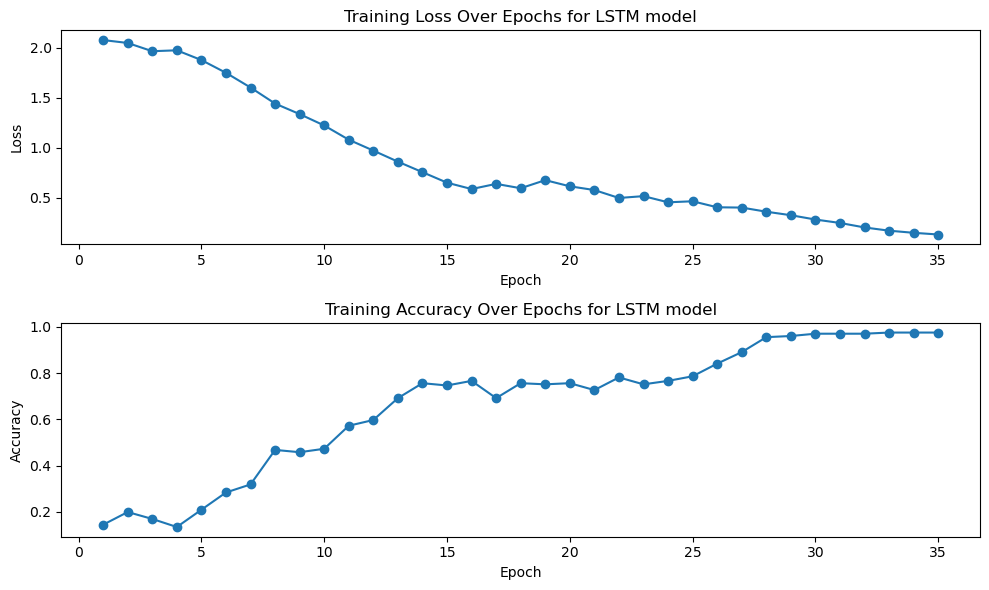

In [43]:
loss_values=model_lstm_2_output.history["loss"]
accuracy_values=model_lstm_2_output.history["accuracy"]

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,6))

#for training loss
ax1.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Over Epochs for LSTM model')

# Plot the training accuracy
ax2.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker='o', linestyle='-')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy Over Epochs for LSTM model')

plt.tight_layout()
plt.show()

______________________________________________________________________________________________________________________________

## model for 2 classes

In [44]:
data_2=pd.read_excel(r"C:\Users\sabaa\OneDrive\Documents\single-multicell data.xlsx")

In [154]:
data_2.head()

,DNA_sequences,hosts
0,ATAGCCCTTTATAAAGTCAGTCTTCTTTTTTCAACTGATGAGTGCG...,single_celled
1,GCCCTTTATAAAGCCATTTTTCTTTTTTTCCTCTTGATGAGTGCGT...,single_celled
2,GCCCTTTATAAAGTCATAATCTTTTTTCGTTTTGATGAGTGCGTTA...,single_celled
3,TTTAGGTGGGACATAGGCACCACAATAAACACCACAAACACCACCA...,single_celled
4,TTAAATACCCCTATTTCTCATTCTATCCCAAGTCTTGTGCCCTGGC...,single_celled


In [12]:
data_2.shape

(279, 2)

In [13]:
data_2.dtypes

DNA_sequences    object
hosts            object
dtype: object

In [155]:
data_2['DNA_sequences']=data_2['DNA_sequences'].apply(lambda x: x.replace('\n',''))
data_2['DNA_sequences']=data_2['DNA_sequences'].apply(lambda x: x.replace('Y',''))
data_2['DNA_sequences']=data_2['DNA_sequences'].apply(lambda x: x.replace('M',''))
data_2['DNA_sequences']=data_2['DNA_sequences'].apply(lambda x: x.replace('R',''))
data_2['DNA_sequences']=data_2['DNA_sequences'].apply(lambda x: x.replace('N',''))
data_2['DNA_sequences']=data_2['DNA_sequences'].apply(lambda x: x.replace('s',''))
data_2['DNA_sequences']=data_2['DNA_sequences'].apply(lambda x: x.replace('S',''))
data_2['DNA_sequences']=data_2['DNA_sequences'].apply(lambda x: x.replace('K',''))
data_2['DNA_sequences']=data_2['DNA_sequences'].apply(lambda x: x.replace('W',''))

In [79]:
data_2.hosts.value_counts()

multicellular    175
single_celled    104
Name: hosts, dtype: int64

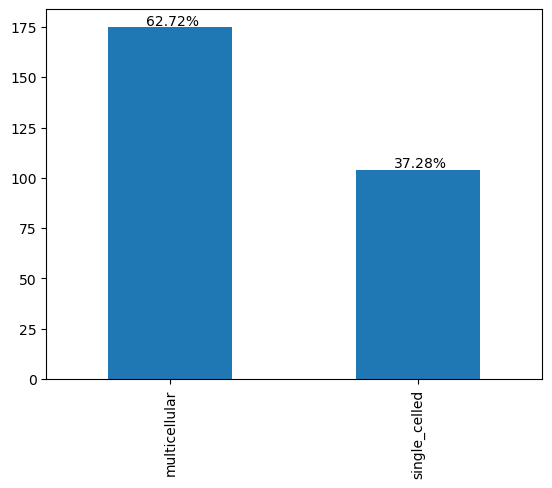

In [52]:
data_2.hosts.value_counts().plot(kind="bar")
plt.text(x=-0.1,y=176,s=str(round((data_2.hosts.value_counts()[0]/len(data_2))*100,2))+"%")
plt.text(x=0.9,y=105,s=str(round((data_2.hosts.value_counts()[1]/len(data_2))*100,2))+"%")
plt.show()

In [167]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(data_2.hosts)
#single_celled=1, multicelled=0


converting sequences to kmers

In [169]:
def getKmers(seq, size):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]

In [157]:
df_kmers_2=pd.DataFrame([data_2['DNA_sequences'].apply(lambda x: ' '.join(getKmers(seq=x,size=6))),y],index=['DNA','host']).T

In [83]:
df_kmers_2.head()

,DNA,host
0,atagcc tagccc agccct gccctt cccttt ccttta cttt...,1
1,gccctt cccttt ccttta ctttat tttata ttataa tata...,1
2,gccctt cccttt ccttta ctttat tttata ttataa tata...,1
3,tttagg ttaggt taggtg aggtgg ggtggg gtggga tggg...,1
4,ttaaat taaata aaatac aatacc ataccc tacccc accc...,1


In [86]:
host_distribution=pd.DataFrame(df_kmers_2.host.value_counts().values,index=("multicellular","single_celled"),columns=["count"])
# Calculate the percentage distribution of 'hosts' values
percentage_0 = str(round((data_2.hosts.value_counts()[0] / len(data_2)) * 100, 2)) + "%"
percentage_1 = str(round((data_2.hosts.value_counts()[1] / len(data_2)) * 100, 2)) + "%"

# Create a DataFrame or dictionary to store the percentages
host_distribution["percentage"] = (percentage_0,percentage_1)
host_distribution["labels"]=(0,1)
host_distribution

,count,percentage,labels
multicellular,175,62.72%,0
single_celled,104,37.28%,1


using count vectorizer to transform the data to document term matrix

In [93]:
from sklearn.feature_extraction.text import CountVectorizer

In [170]:
X=df_kmers_2.DNA
cv = CountVectorizer() 
cv.fit(X)
X=cv.transform(X)

In [171]:
#oversampling rectification
from imblearn.over_sampling import SMOTE
X, y = SMOTE().fit_resample(X, y)

In [172]:
#Train test split
x_train,x_test,y_train,y_test=train_test_split(X,y)

In [173]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.naive_bayes import MultinomialNB

In [104]:
accuracy = []
f1_score_= []
precision= []
recall= []

knn = KNeighborsClassifier()
mnb= MultinomialNB()
nb = GaussianNB()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
gb = GradientBoostingClassifier()
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1)  # Adjust hyperparameters accordingly

models = [knn, mnb, nb, dt, rf, ada, gb, xgb]

for model in models:
    mod=model.fit(x_train.toarray(), y_train)
    y_pred = mod.predict(x_test.toarray())
    
    model_accuracy = accuracy_score(y_test, y_pred)
    model_f1_score=f1_score(y_test,y_pred,average='weighted')
    model_precision=precision_score(y_test,y_pred,average='weighted')
    model_recall=recall_score(y_test,y_pred,average='weighted')
    
    accuracy.append(model_accuracy)
    precision.append(model_precision)
    recall.append(model_recall)

print("accuracy: ",accuracy)
print("f1_score: ",f1_score)
print("precision: ",precision)
print("recall: ",recall)

accuracy:  [0.7613636363636364, 0.7386363636363636, 0.7727272727272727, 0.7840909090909091, 0.8522727272727273, 0.8636363636363636, 0.875, 0.8522727272727273]
f1_score:  <function f1_score at 0x0000021B66A0C0D0>
precision:  [0.7989109848484849, 0.7400203962703963, 0.7733896340453718, 0.7885047846889951, 0.8517404436522082, 0.8636363636363636, 0.875801282051282, 0.8560406698564594]
recall:  [0.7613636363636364, 0.7386363636363636, 0.7727272727272727, 0.7840909090909091, 0.8522727272727273, 0.8636363636363636, 0.875, 0.8522727272727273]


In [105]:
df_accuracy=pd.DataFrame({"MODEL":["KNeighborsClassifier","MultinomialNB","NaiveBayes","DecisionTree","RandomForest",
                                   "AdaBoostClassifier","GradientBoosting"
                          ,"XGBClassifier"],"accuracy(k=6)":accuracy,
                          "precision(k=6)":precision,"recall(k=6)":recall})
df_accuracy

,MODEL,accuracy(k=6),precision(k=6),recall(k=6)
0,KNeighborsClassifier,0.761364,0.798911,0.761364
1,MultinomialNB,0.738636,0.740020,0.738636
2,NaiveBayes,0.772727,0.773390,0.772727
3,DecisionTree,0.784091,0.788505,0.784091
4,RandomForest,0.852273,0.851740,0.852273
5,AdaBoostClassifier,0.863636,0.863636,0.863636
6,GradientBoosting,0.875000,0.875801,0.875000
7,XGBClassifier,0.852273,0.856041,0.852273


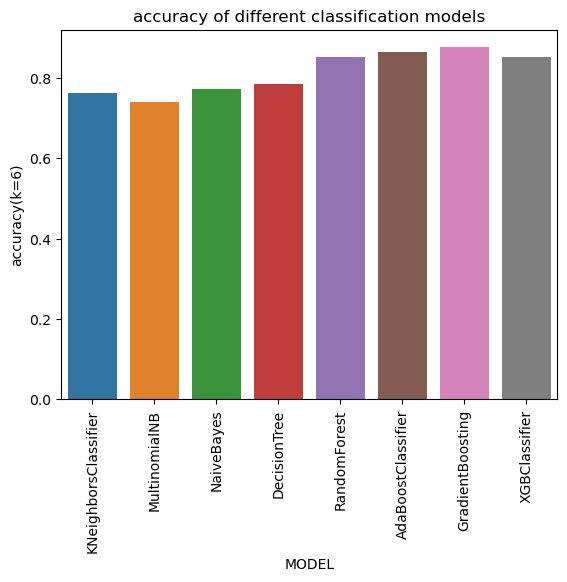

In [106]:
sns.barplot(data=df_accuracy,x="MODEL",y="accuracy(k=6)")
plt.xticks(rotation="vertical")
plt.title("accuracy of different classification models")
plt.show()

In [107]:
#checking the overfitting:
accuracy_training_data=[]
accuracy_test_data=[]


knn = KNeighborsClassifier()
mnb= MultinomialNB()
nb = GaussianNB()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
gb = GradientBoostingClassifier()
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1)  # Adjust hyperparameters accordingly

models = [knn, mnb, nb, dt, rf, ada, gb, xgb]

for model in models:
    mod=model.fit(x_train.toarray(), y_train)
    y_train_pred = mod.predict(x_train.toarray())
    y_test_pred = mod.predict(x_test.toarray())
    
    model_training_accuracy = accuracy_score(y_train, y_train_pred)
    model_test_accuracy = accuracy_score(y_test, y_test_pred)
    
    accuracy_training_data.append(model_training_accuracy)
    accuracy_test_data.append(model_test_accuracy)

In [117]:
df_overfit_check=pd.DataFrame({"accuracy_training_data":accuracy_training_data,
                          "accuracy_test_data":accuracy_test_data},index=["KNeighborsClassifier","MultinomialNB","NaiveBayes","DecisionTree","RandomForest",
                                   "AdaBoostClassifier","GradientBoosting"
                          ,"XGBClassifier"])
df_overfit_check

,accuracy_training_data,accuracy_test_data
KNeighborsClassifier,0.786260,0.761364
MultinomialNB,0.748092,0.738636
NaiveBayes,0.656489,0.772727
DecisionTree,0.996183,0.727273
RandomForest,0.996183,0.863636
AdaBoostClassifier,0.996183,0.863636
GradientBoosting,0.996183,0.863636
XGBClassifier,0.996183,0.852273


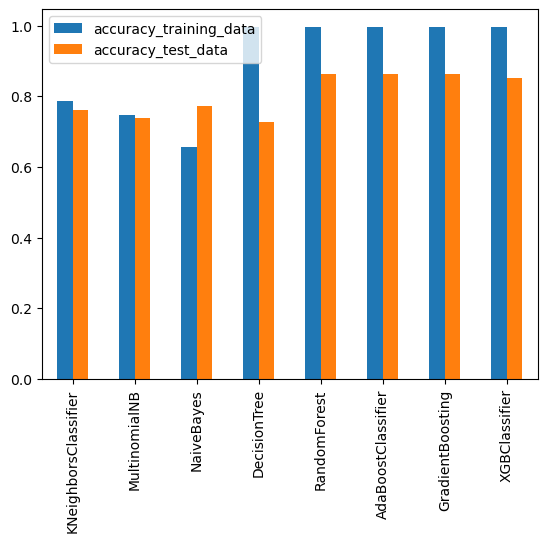

In [118]:
df_overfit_check.plot(kind="bar")
plt.xticks(rotation=90)
plt.show()

using nultinomial naive bayes

In [181]:
def Kmers_funct(seq, size=5):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]

In [182]:
data_2['words'] = data_2.apply(lambda x: Kmers_funct(x['DNA_sequences']), axis=1)
data_2 = data_2.drop('DNA_sequences', axis=1)

In [183]:
sequence = list(data_2['words'])
for item in range(len(sequence)):
    sequence[item] = ' '.join(sequence[item])
#separate labels
Yhost = data_2.iloc[:, 0].values 

In [184]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4)) #The n-gram size of 4 is previously determined by testing
X_Sequence = cv.fit_transform(sequence)

In [185]:
X_Sequence.shape

(279, 117906)

In [191]:
X=X_Sequence
y=Yhost
x_train,x_test,y_train,y_test=train_test_split(X,y)

In [194]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.5)
classifier.fit(x_train, y_train)

MultinomialNB(alpha=0.5)

In [196]:
y_pred = classifier.predict(x_test)

In [197]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix for predictions on human test DNA sequence\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix for predictions on human test DNA sequence

Predicted      multicellular  single_celled
Actual                                     
multicellular             39              6
single_celled              8             17
accuracy = 0.800 
precision = 0.797 
recall = 0.800 
f1 = 0.798


## DEEP LEARNING MODELS:

### Applying CNN Model

In [71]:
import keras
from keras.models import Sequential
from keras.layers import LSTM ,Bidirectional ,Dense,Activation ,Input
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import tensorflow as tf
from typing import List
from typing import List
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from pathlib import Path

In [72]:
def build_kmers(sequence:str, k:int)->List[str]:
    """
        inputs:
                sequence: a sting that represent a DNA
                k: parameter to produce k-mer list
        return: list of kmers
    """
    kmers = []
    n_kmers = len(sequence) - k + 1

    for i in range(n_kmers):
        kmer = sequence[i:i + k]
        kmers.append(kmer)

    return kmers

In [73]:
data_2["len"] =data_2["DNA_sequences"].apply(lambda x:len(x))
data_2

,DNA_sequences,hosts,len,k-mers,vec
0,ATAGCCCTTTATAAAGTCAGTCTTCTTTTTTCAACTGATGAGTGCG...,single_celled,17855,"[ATAGC, TAGCC, AGCCC, GCCCT, CCCTT, CCTTT, CTT...","[0.012399773544295223, 0.046965433223848, -0.0..."
1,GCCCTTTATAAAGCCATTTTTCTTTTTTTCCTCTTGATGAGTGCGT...,single_celled,16710,"[GCCCT, CCCTT, CCTTT, CTTTA, TTTAT, TTATA, TAT...","[0.04423111372861986, 0.0035352329369713487, 0..."
2,GCCCTTTATAAAGTCATAATCTTTTTTCGTTTTGATGAGTGCGTTA...,single_celled,17635,"[GCCCT, CCCTT, CCTTT, CTTTA, TTTAT, TTATA, TAT...","[0.044307925794832635, 0.049663228452925014, -..."
3,TTTAGGTGGGACATAGGCACCACAATAAACACCACAAACACCACCA...,single_celled,15910,"[TTTAG, TTAGG, TAGGT, AGGTG, GGTGG, GTGGG, TGG...","[0.04410436481219431, 0.02498892859816544, 0.0..."
4,TTAAATACCCCTATTTCTCATTCTATCCCAAGTCTTGTGCCCTGGC...,single_celled,13967,"[TTAAA, TAAAT, AAATA, AATAC, ATACC, TACCC, ACC...","[0.04757513191057538, 0.22608371461953336, -0...."
5,CCTTGACCCACCGCCAAGCCACCCTCTACCAACGCCAAACCACCTC...,single_celled,28743,"[CCTTG, CTTGA, TTGAC, TGACC, GACCC, ACCCA, CCC...","[-0.03222244492358973, 0.22179342481996092, -0..."
6,TGACACGCTATTTGTCTGTACTTTAAAGATTGATAGAAACGCGTGT...,single_celled,21234,"[TGACA, GACAC, ACACG, CACGC, ACGCT, CGCTA, GCT...","[0.03432906629780149, 0.21031158812826337, -0...."
7,CGGGGGGGAGCATGTGGTTTGCGGTTTGAGGTTCGCACTTGTGATT...,single_celled,21169,"[CGGGG, GGGGG, GGGGG, GGGGG, GGGGA, GGGAG, GGA...","[-0.006340796612936051, 0.06787417285323478, -..."
8,GTATATATACGGTAAAATACCCAGACGATATTCTCCGTCAGTTTGA...,single_celled,32243,"[GTATA, TATAT, ATATA, TATAT, ATATA, TATAC, ATA...","[0.0783905599827807, -0.03978424455656356, 0.1..."
9,CGAGAGAGAAATTTTATAAGACGTATTAGACACGGATACGTCGTAT...,single_celled,32765,"[CGAGA, GAGAG, AGAGA, GAGAG, AGAGA, GAGAA, AGA...","[0.08020583547865216, -0.039377055425702454, 0..."


In [74]:
data_2["k-mers"] = data_2["DNA_sequences"].apply(lambda x :build_kmers(x,5))
data_2

,DNA_sequences,hosts,len,k-mers,vec
0,ATAGCCCTTTATAAAGTCAGTCTTCTTTTTTCAACTGATGAGTGCG...,single_celled,17855,"[ATAGC, TAGCC, AGCCC, GCCCT, CCCTT, CCTTT, CTT...","[0.012399773544295223, 0.046965433223848, -0.0..."
1,GCCCTTTATAAAGCCATTTTTCTTTTTTTCCTCTTGATGAGTGCGT...,single_celled,16710,"[GCCCT, CCCTT, CCTTT, CTTTA, TTTAT, TTATA, TAT...","[0.04423111372861986, 0.0035352329369713487, 0..."
2,GCCCTTTATAAAGTCATAATCTTTTTTCGTTTTGATGAGTGCGTTA...,single_celled,17635,"[GCCCT, CCCTT, CCTTT, CTTTA, TTTAT, TTATA, TAT...","[0.044307925794832635, 0.049663228452925014, -..."
3,TTTAGGTGGGACATAGGCACCACAATAAACACCACAAACACCACCA...,single_celled,15910,"[TTTAG, TTAGG, TAGGT, AGGTG, GGTGG, GTGGG, TGG...","[0.04410436481219431, 0.02498892859816544, 0.0..."
4,TTAAATACCCCTATTTCTCATTCTATCCCAAGTCTTGTGCCCTGGC...,single_celled,13967,"[TTAAA, TAAAT, AAATA, AATAC, ATACC, TACCC, ACC...","[0.04757513191057538, 0.22608371461953336, -0...."
5,CCTTGACCCACCGCCAAGCCACCCTCTACCAACGCCAAACCACCTC...,single_celled,28743,"[CCTTG, CTTGA, TTGAC, TGACC, GACCC, ACCCA, CCC...","[-0.03222244492358973, 0.22179342481996092, -0..."
6,TGACACGCTATTTGTCTGTACTTTAAAGATTGATAGAAACGCGTGT...,single_celled,21234,"[TGACA, GACAC, ACACG, CACGC, ACGCT, CGCTA, GCT...","[0.03432906629780149, 0.21031158812826337, -0...."
7,CGGGGGGGAGCATGTGGTTTGCGGTTTGAGGTTCGCACTTGTGATT...,single_celled,21169,"[CGGGG, GGGGG, GGGGG, GGGGG, GGGGA, GGGAG, GGA...","[-0.006340796612936051, 0.06787417285323478, -..."
8,GTATATATACGGTAAAATACCCAGACGATATTCTCCGTCAGTTTGA...,single_celled,32243,"[GTATA, TATAT, ATATA, TATAT, ATATA, TATAC, ATA...","[0.0783905599827807, -0.03978424455656356, 0.1..."
9,CGAGAGAGAAATTTTATAAGACGTATTAGACACGGATACGTCGTAT...,single_celled,32765,"[CGAGA, GAGAG, AGAGA, GAGAG, AGAGA, GAGAA, AGA...","[0.08020583547865216, -0.039377055425702454, 0..."


# wordEmbedding

In [75]:
class DocToVec:
    
    def __init__(self, dataset:List[List] , vec_size = 200 , model_path = 'word2vec.model'):
        """ Here we train our model and calculate tf-idf weights.

        Args:
            dataset (List[List]): Each item of this list is a list of tokens obtained from a document.
            vec_size (int, optional): The size of the vector of each document. Defaults to 200.
            model_path (str, optional): The path of pre-trained model. If there is no file in the specified 
            path, It trains a model with the dataset and saves the trained model. Defaults to 'word2vec.model'.
        """

        self.vec_size = vec_size
        
        
        
        if not Path(model_path).is_file():
            print('There is no pre-trained model. Going to train a model ...')
            self.wordToVecModel = Word2Vec(
                window = 10,
                min_count=2,
                workers=4,
                vector_size = self.vec_size
            )
        
            self.wordToVecModel.build_vocab(dataset)
            
            self.wordToVecModel.train(
                dataset,
                total_examples = self.wordToVecModel.corpus_count,
                epochs = 20,
            )
            
            self.wordToVecModel.save(model_path)
            
        else:
            
            print('Loading the model ...')
            self.wordToVecModel = Word2Vec.load(model_path)
        
        con_train_data = [" ".join(a) for a in dataset]
        
        self.tfIdfVectorizer=TfidfVectorizer(use_idf=True,
                                        dtype = np.float64,
                                        lowercase = False,
                                        vocabulary = self.wordToVecModel.wv.index_to_key)
        
        self.tfIdfVectorizer.fit(con_train_data)
        
        dictionary = self.tfIdfVectorizer.get_feature_names_out()
        self.dictToNum = {d:i for i,d in enumerate(dictionary)}
        
        
    def embed(self, tokens:List):
        """Maps the input to a vector

        Args:
            tokens (List): List of tokens (don't forget to do preprocessing before 
            extracting tokens)

        Returns:
            Numpy Array: The vector of document
        """
        
        ti = self.tfIdfVectorizer.transform([" ".join(tokens)])
        
        weights = np.squeeze(np.asarray(ti[0].T.todense()))
        
        vec = np.zeros((self.vec_size,))
        sum_weights = 0
        for k in set(tokens):
            try:
                word_vec = self.wordToVecModel.wv[k]
                weight = weights[self.dictToNum[k]]
                vec += word_vec * weight
                sum_weights += weight
            except KeyError:
                pass
        vec /= sum_weights
        return vec

In [76]:
word_to_vec_model = DocToVec(dataset=data_2["k-mers"].to_list())
data_2["vec"]= data_2["k-mers"].apply(lambda x:word_to_vec_model.embed(x))
data_2.head()

Loading the model ...


,DNA_sequences,hosts,len,k-mers,vec
0,ATAGCCCTTTATAAAGTCAGTCTTCTTTTTTCAACTGATGAGTGCG...,single_celled,17855,"[ATAGC, TAGCC, AGCCC, GCCCT, CCCTT, CCTTT, CTT...","[0.012399773544295223, 0.046965433223848, -0.0..."
1,GCCCTTTATAAAGCCATTTTTCTTTTTTTCCTCTTGATGAGTGCGT...,single_celled,16710,"[GCCCT, CCCTT, CCTTT, CTTTA, TTTAT, TTATA, TAT...","[0.04423111372861986, 0.0035352329369713487, 0..."
2,GCCCTTTATAAAGTCATAATCTTTTTTCGTTTTGATGAGTGCGTTA...,single_celled,17635,"[GCCCT, CCCTT, CCTTT, CTTTA, TTTAT, TTATA, TAT...","[0.044307925794832635, 0.049663228452925014, -..."
3,TTTAGGTGGGACATAGGCACCACAATAAACACCACAAACACCACCA...,single_celled,15910,"[TTTAG, TTAGG, TAGGT, AGGTG, GGTGG, GTGGG, TGG...","[0.04410436481219431, 0.02498892859816544, 0.0..."
4,TTAAATACCCCTATTTCTCATTCTATCCCAAGTCTTGTGCCCTGGC...,single_celled,13967,"[TTAAA, TAAAT, AAATA, AATAC, ATACC, TACCC, ACC...","[0.04757513191057538, 0.22608371461953336, -0...."


In [77]:
Y= data_2["hosts"].to_list()

In [78]:
X = np.array(data_2["vec"].to_list())

# change to np
le = preprocessing.LabelEncoder()
Y =le.fit_transform(Y)

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [80]:
model_cnn_2_classes =Sequential()
model_cnn_2_classes.add(Input(shape=(200,)))
model_cnn_2_classes.add(Dense(100, activation='relu'))
model_cnn_2_classes.add(Dense(50,activation='relu'))
model_cnn_2_classes.add(Dense(8))

In [81]:
model_cnn_2_classes.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 100)               20100     
                                                                 
 dense_22 (Dense)            (None, 50)                5050      
                                                                 
 dense_23 (Dense)            (None, 8)                 408       
                                                                 
Total params: 25558 (99.84 KB)
Trainable params: 25558 (99.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [82]:
from keras import losses 
from keras import optimizers 
from keras import metrics 
#model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])    

#model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])    

model_cnn_2_classes.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'adam', metrics = [metrics.categorical_accuracy])

In [83]:
model_cnn_2_classes = model_cnn_2_classes.fit(X_train,Y_train,epochs=34,batch_size=32,verbose=1,validation_data=(X_test,Y_test),)

Epoch 1/34
7/7 [==============================] - 1s 34ms/step - loss: 8.5058 - categorical_accuracy: 0.0000e+00 - val_loss: 3.3992 - val_categorical_accuracy: 0.0000e+00
Epoch 2/34
7/7 [==============================] - 0s 9ms/step - loss: 2.5563 - categorical_accuracy: 0.0000e+00 - val_loss: 2.2672 - val_categorical_accuracy: 0.0357
Epoch 3/34
7/7 [==============================] - 0s 10ms/step - loss: 2.1172 - categorical_accuracy: 0.0135 - val_loss: 2.2606 - val_categorical_accuracy: 0.0000e+00
Epoch 4/34
7/7 [==============================] - 0s 10ms/step - loss: 2.0794 - categorical_accuracy: 0.0090 - val_loss: 2.2463 - val_categorical_accuracy: 0.0000e+00
Epoch 5/34
7/7 [==============================] - 0s 9ms/step - loss: 2.0794 - categorical_accuracy: 0.0090 - val_loss: 2.2249 - val_categorical_accuracy: 0.0000e+00
Epoch 6/34
7/7 [==============================] - 0s 10ms/step - loss: 2.0794 - categorical_accuracy: 0.0090 - val_loss: 2.0794 - val_categorical_accuracy: 0.0000e

In [84]:
# Evaluate the model on the test data
loss, accuracy = model_cnn_2_classes.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

AttributeError: 'History' object has no attribute 'evaluate'

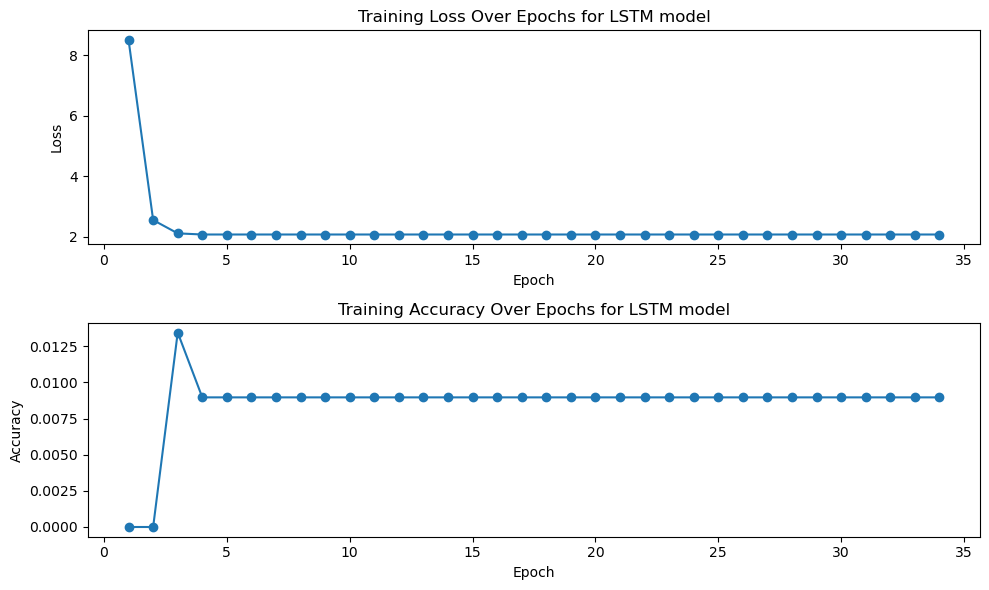

In [86]:
loss_values=model_cnn_2_classes.history["loss"]
accuracy_values=model_cnn_2_classes.history["categorical_accuracy"]

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,6))

#for training loss
ax1.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Over Epochs for LSTM model')

# Plot the training accuracy
ax2.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker='o', linestyle='-')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy Over Epochs for LSTM model')

plt.tight_layout()
plt.show()

## LSTM

In [87]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Prepare the input sequences
max_sequence_length = 100  # You can adjust this based on your data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_2['DNA_sequences'])
sequences = tokenizer.texts_to_sequences(data_2['DNA_sequences'])
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Prepare the target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data_2['hosts'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
model_lstm_2_classes = Sequential()
model_lstm_2_classes.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_sequence_length))
model_lstm_2_classes.add(LSTM(128, return_sequences=True))
model_lstm_2_classes.add(LSTM(64))
model_lstm_2_classes.add(Dense(8, activation='softmax')
                        model_cnn_c_classes)  # 8 output classes, one for each host

# Compile the model
model_lstm_2_classes.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model_lstm_2_classes the model
model_lstm_2_classes=model_lstm_2_classes.fit(X_train, y_train, epochs=35, batch_size=64, validation_split=0.2)

Epoch 1/35
3/3 [==============================] - 4s 526ms/step - loss: 2.0651 - accuracy: 0.4326 - val_loss: 2.0190 - val_accuracy: 0.6889
Epoch 2/35
3/3 [==============================] - 1s 195ms/step - loss: 1.9772 - accuracy: 0.6236 - val_loss: 1.8308 - val_accuracy: 0.6889
Epoch 3/35
3/3 [==============================] - 1s 194ms/step - loss: 1.6384 - accuracy: 0.6236 - val_loss: 0.8756 - val_accuracy: 0.6889
Epoch 4/35
3/3 [==============================] - 1s 217ms/step - loss: 0.8709 - accuracy: 0.6236 - val_loss: 0.6912 - val_accuracy: 0.6889
Epoch 5/35
3/3 [==============================] - 1s 217ms/step - loss: 0.7295 - accuracy: 0.6236 - val_loss: 0.6914 - val_accuracy: 0.6889
Epoch 6/35
3/3 [==============================] - 1s 210ms/step - loss: 0.7027 - accuracy: 0.6236 - val_loss: 0.6580 - val_accuracy: 0.6889
Epoch 7/35
3/3 [==============================] - 1s 190ms/step - loss: 0.6814 - accuracy: 0.6236 - val_loss: 0.6316 - val_accuracy: 0.6889
Epoch 8/35
3/3 [====

In [88]:
# Evaluate the model on the test data
loss, accuracy = model_lstm_2_classes.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

AttributeError: 'History' object has no attribute 'evaluate'

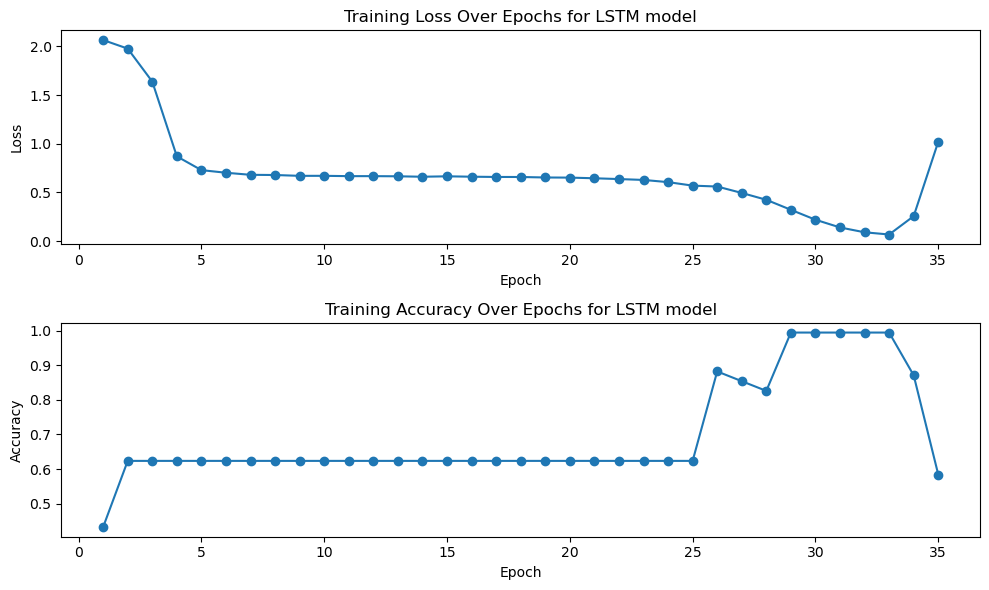

In [89]:
loss_values=model_lstm_2_classes.history["loss"]
accuracy_values=model_lstm_2_classes.history["accuracy"]

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,6))

#for training loss
ax1.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Over Epochs for LSTM model')

# Plot the training accuracy
ax2.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker='o', linestyle='-')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy Over Epochs for LSTM model')

plt.tight_layout()
plt.show()